In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import geopandas as gpd
import rasterio
from shapely.geometry import mapping
import rasterio.mask
from rasterio.mask import mask
#from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier # para usar un modelo de clasificación KNN
from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn import tree
# import graphviz


In [22]:
#Levanto en X, Y los datos etiquetados, como antes
#Datos del raster y del shp

path_proc = '../data/proc/'
path_out = '../data/out/'
path_shp = '../data/raw_data/vector/'
raster_fn = path_proc + 'LT05_L2SP_229082_19900620_20200916_02_T1_SR_STACK_MERGE_II_ESCALA_GENERAL_MASK_NO_DATA_0.tif'
rois_shp = gpd.read_file(path_shp+'aoi_tucu_iii.geojson')

#Leo los ROIS
with rasterio.open(raster_fn) as src:
    d=src.count #cantidad de atributos = cantidad de bandas en el raster

nodata=-255 #elijo un valor raro para nodata

clases=list(set(rois_shp['clase']))
clases.sort() #numero las clases de los ROIs alfabéticamente
clase_dict = {clase:i for i, clase in enumerate(clases)}

#Preparo colección de atributos etiquetados. Comienza con 0 datos
X = np.zeros([0,d],dtype = np.float32) #array con todos los atributos
Y = np.zeros([0],dtype=int)            #array con sus etiquetas

with rasterio.open(raster_fn) as src:
    for index, row in rois_shp.iterrows():
        geom_sh = row['geometry']
        clase = row['clase']
        geom_GJ = [mapping(geom_sh)]
        clip, _transform = mask(src, geom_GJ, crop=True,nodata=nodata)
        d,x,y = clip.shape
        D = list(clip.reshape([d,x*y]).T)
        D = [p for p in D if (not (p==nodata).prod())]
        DX = np.array(D)        
        DY = np.repeat(clase_dict[clase],len(D))
        X = np.concatenate((X,DX))
        Y = np.concatenate((Y,DY))

In [3]:
#separo en train y test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25)

In [4]:
n_splits = 5
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
print(skf)

StratifiedKFold(n_splits=5, random_state=None, shuffle=True)


In [5]:
valores_prof = [7,8,9,10]
valores_estim = [100,120,150,180,200]

resultados_test = np.zeros((n_splits, len(valores_prof), len(valores_estim)))
resultados_train = np.zeros((n_splits, len(valores_prof), len(valores_estim)))

split = 0
for train_index, test_index in skf.split(X,Y):
    print(f"Fold {split + 1}:")
    for i,d in enumerate(valores_prof):
        print(f" - arboles de profundidad {d}")
        for j,n in enumerate(valores_estim):
            X_train, X_test = X[train_index,:], X[test_index,:]
            Y_train, Y_test = Y[train_index], Y[test_index]
            model = RandomForestClassifier(n_estimators = n, max_depth = d)
            model.fit(X_train, Y_train) 
            Y_pred = model.predict(X_test)
            Y_pred_train = model.predict(X_train)
            acc_test = metrics.accuracy_score(Y_test, Y_pred)
            acc_train = metrics.accuracy_score(Y_train, Y_pred_train)
            resultados_test[split, i, j] = acc_test
            resultados_train[split, i, j] = acc_train
    split += 1

Fold 1:
 - arboles de profundidad 7
 - arboles de profundidad 8
 - arboles de profundidad 9
 - arboles de profundidad 10
Fold 2:
 - arboles de profundidad 7
 - arboles de profundidad 8
 - arboles de profundidad 9
 - arboles de profundidad 10
Fold 3:
 - arboles de profundidad 7
 - arboles de profundidad 8
 - arboles de profundidad 9
 - arboles de profundidad 10
Fold 4:
 - arboles de profundidad 7
 - arboles de profundidad 8
 - arboles de profundidad 9
 - arboles de profundidad 10
Fold 5:
 - arboles de profundidad 7
 - arboles de profundidad 8
 - arboles de profundidad 9
 - arboles de profundidad 10


In [6]:
promedios_test = np.mean(resultados_test, axis = 0) 

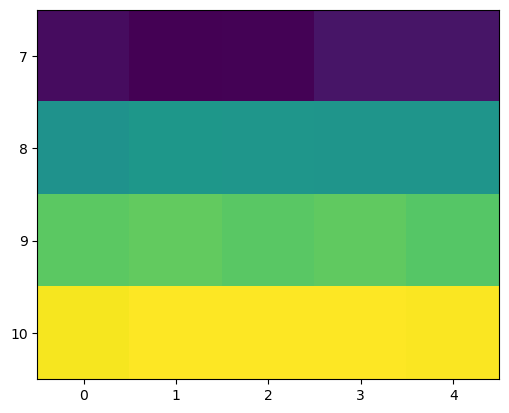

In [7]:
#plt.imshow(promedios_test)

fig, ax = plt.subplots()
im = ax.imshow(promedios_test)

# Show all ticks and label them with the respective list entries
ax.set_yticks(np.arange(len(valores_prof)), labels=[str(v) for v in valores_prof])
ax.set_xticks(np.arange(len(valores_estim)))#, labels=valores_estim)

In [8]:
ind = np.unravel_index(np.argmax(promedios_test, axis=None), promedios_test.shape)
opt_d = valores_prof[ind[0]]
opt_n = valores_estim[ind[1]]
max_acc = promedios_test[ind]

print(f"El mejor promedio fue obtenido para profundidad {opt_d} y {opt_n} arboles, con una exactitud de {max_acc:.3f}")

El mejor promedio fue obtenido para profundidad 10 y 180 arboles, con una exactitud de 0.948


In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score as kappa

In [10]:
acc = accuracy_score(Y_test, Y_pred)
print(f'accuracy: {acc:.2f}')

k = kappa(Y_test, Y_pred)
print(f'kappa index: {k:.2f}')

accuracy: 0.95
kappa index: 0.92


In [11]:
#Entrenemos un arbol de profundidad 11
clf = RandomForestClassifier(n_estimators = 180, max_depth = 10)
clf = clf.fit(X, Y)

In [12]:
#lo evaluo
Y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(Y_test, Y_pred))

Accuracy: 0.948818523272952


In [13]:
M=confusion_matrix(Y_test, Y_pred)
print('Matriz de confusión:\n',M)

Matriz de confusión:
 [[  989   265    12   153   529    10]
 [   83 11284     0    10   350     0]
 [    7     4 51397   358   959     6]
 [  125    27  1143 30773  1048    13]
 [   61   167  2658   431 64136     0]
 [    3     0    20   101    69  1073]]


Text(95.72222222222221, 0.5, 'Thruth')

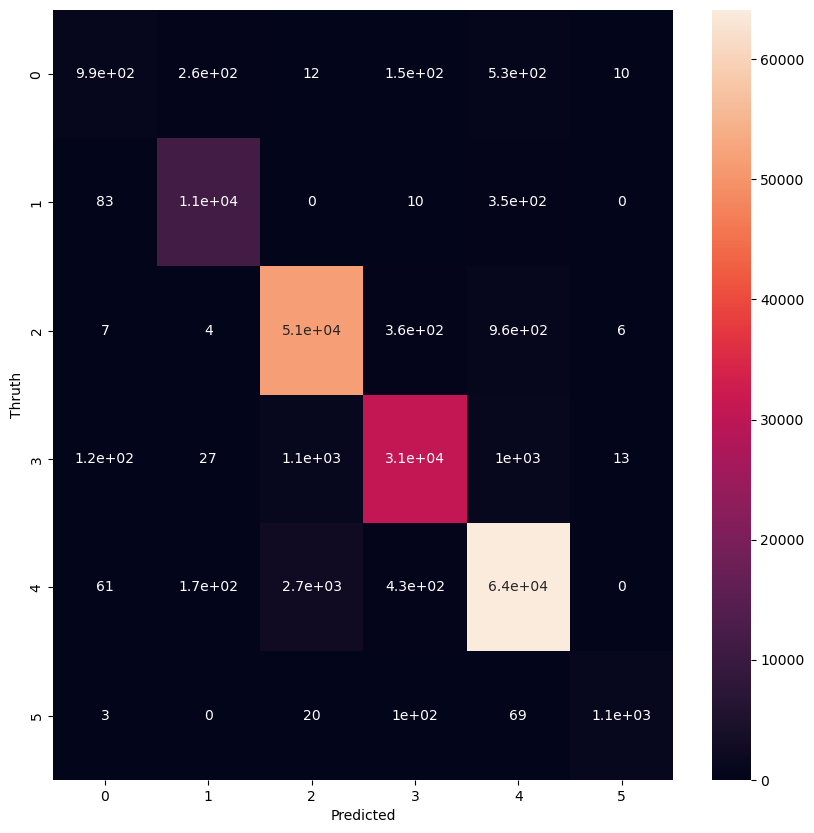

In [23]:
import seaborn as sn
plt.figure(figsize=(10,10))
sn.heatmap(M, annot=True)
plt.xlabel ('Predicted')
plt.ylabel ('Thruth')

In [15]:
#Leo la imágen completa
raster_fn = path_out + 'TUCUMAN_MOSAIC_CLIP_COMPRESS_MASK.tif'
with rasterio.open(raster_fn) as src:
    img = src.read()
    crs = src.crs
    gt = src.transform
img.shape
d,x,y = img.shape

#y uso el modelo para clasificar toda la imagen
Y_pred = clf.predict(img.reshape([d,x*y]).T)

In [16]:
#plt.figure(figsize=(26,20),dpi=300)
#plt.imshow(Y_pred.reshape([x,y]),cmap='gnuplot2')
#plt.show()

In [17]:
np.unique(Y_pred)

array([0, 1, 2, 3, 4, 5])

In [18]:
def guardar_GTiff(fn, crs, transform, mat, meta=None, nodata=None, bandnames=[]):
    if len(mat.shape)==2:
        count=1
    else:
        count=mat.shape[0]

    if not meta:
        meta = {}

    meta['driver'] = 'GTiff'
    meta['height'] = mat.shape[-2]
    meta['width'] = mat.shape[-1]
    meta['count'] = count
    meta['crs'] = crs
    meta['transform'] = transform

    if 'dtype' not in meta: #if no datatype is specified, use float32
        meta['dtype'] = np.float32
    

    if nodata:
        meta['nodata'] = nodata

    with rasterio.open(fn, 'w', **meta) as dst:
        if count==1:
            dst.write(mat.astype(np.float32), 1)
            if bandnames:
                dst.set_band_description(1, bandnames[0])
        else:
            for b in range(count):
                dst.write(mat[b].astype(np.float32), b+1)
            for b,bandname in enumerate(bandnames):
                dst.set_band_description(b+1, bandname)


In [19]:
#Guardo un resultado
class_img = Y_pred.reshape([x,y])
guardar_GTiff(path_out + 'Class_IMG_CLF_10_180.tif',crs,gt,class_img)

In [24]:
rois_shp = gpd.read_file(path_shp+'aoi_tucu_iii.geojson')
rois_shp.head(10)

,clase,id,area,tipo,geometry
0,Arbustal,1,28373.067,5,"POLYGON ((273891.330 7005477.165, 274009.619 7..."
1,Arbustal,2,102358.057,5,"POLYGON ((258976.548 6942488.894, 258947.832 6..."
2,Bosque cerrado con estrato arboreo,3,49642.257,0,"POLYGON ((261707.196 7020200.890, 261701.911 7..."
3,Bosque cerrado con estrato arboreo,4,36795.855,0,"POLYGON ((261080.403 7019284.145, 261076.198 7..."
4,Bosque cerrado con estrato arboreo,5,140002.999,0,"POLYGON ((262583.308 7022141.941, 262578.267 7..."
5,Bosque cerrado con estrato arboreo,6,84719.620,0,"POLYGON ((263361.206 7020959.585, 263354.122 7..."
6,Bosque cerrado con estrato arboreo,7,57340.206,0,"POLYGON ((261105.429 6942911.557, 260993.737 6..."
7,Arbustal,8,13724.961,5,"POLYGON ((261218.942 6942632.327, 261192.840 6..."
8,Arbustal,9,105196.266,5,"POLYGON ((259251.585 6942693.029, 259161.139 6..."
9,Arbustal,10,47526.234,5,"POLYGON ((259048.385 6942770.424, 259228.670 6..."
